# Домашнее задание 3. 

## Предсказание пользовательской оценки отеля по тексту отзыва.

Сделал **Пешков Максим**

группа **ИАД-4**

#### Мои источники

1. Для первой и второй части:

 Семинар 10 с прошлого года (+ домашка с прошлого года по текстам)

  https://github.com/KovalevEvgeny/minor2020-iad4/blob/master/sem10_texts/sem10_texts.ipynb

  Семинар 9 с этого года
  https://github.com/hse-ds/iad-deep-learning/blob/master/sem09/sem09.ipynb
2. Для третьей части

  Семинар 10. с этого года
https://github.com/hse-ds/iad-deep-learning/blob/master/sem10/sem10.ipynb

  Семинар 11.
https://github.com/hse-ds/iad-deep-learning/blob/master/sem11/seminar-task.ipynb

  Kaggle:

  https://www.kaggle.com/gabrielloye/simple-lstm-using-pytorch

  https://www.kaggle.com/jovian/jvn-lstm-multiclass-text-classification-b8200


#### Данные:

Мы собрали для вас отзывы по 1500 отелям из совершенно разных уголков мира. Что это за отели - секрет. Вам дан текст отзыва и пользовательская оценка отеля. Ваша задача - научиться предсказывать оценку отеля по отзыву. Данные можно скачать [тут](https://www.kaggle.com/c/hseds-texts-2020/data?select=train.csv).

Каждое ревью состоит из двух текстов: positive и negative - плюсы и минусы отеля. В столбце score находится оценка пользователя - вещественное число 0 до 10. Вам нужно извлечь признаки из этих текстов и предсказать по ним оценку.

Главная метрика - Mean Absolute Error (MAE). Во всех частях домашней работы вам нужно получить значение MAE не превышающее 1. В противном случае мы будем вынуждены не засчитать задание :( 

Для измерения качества вашей модели используйте разбиение данных на train и test и замеряйте качество на тестовой части.

In [1]:
!wget https://www.dropbox.com/s/xls8dvvcnkt9nua/hseds-texts-2020.zip?dl=0

--2020-12-20 16:36:21--  https://www.dropbox.com/s/xls8dvvcnkt9nua/hseds-texts-2020.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xls8dvvcnkt9nua/hseds-texts-2020.zip [following]
--2020-12-20 16:36:21--  https://www.dropbox.com/s/raw/xls8dvvcnkt9nua/hseds-texts-2020.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc86509ee4bc9fe7bde3e20d6f2a.dl.dropboxusercontent.com/cd/0/inline/BFc6xiyifu7wJXDFoadTq2jhXp5FPW9HYzK6kQ6BKdvrlDMuADszs2dW1vrVWQErTsjxqY8q9ctu-TNf8QFZMH5J8XPv7Veg4GVZ11vUjNECbFyeub7PK8YO-xeOk08AJws/file# [following]
--2020-12-20 16:36:21--  https://uc86509ee4bc9fe7bde3e20d6f2a.dl.dropboxusercontent.com/cd/0/inline/BFc6xiyifu7wJXDFoadTq2jhXp5FPW9HYzK6kQ6BKdvrlDMuADszs2dW1vrVWQErTsjxqY8q9ctu-TNf8Q

In [2]:
!unzip -q hseds-texts-2020.zip?dl=0

replace sample_submission(1).csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
PATH_TO_TRAIN_DATA = 'train.csv'

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv(PATH_TO_TRAIN_DATA)
df.head()

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,There were issues with the wifi connection,No Positive,7.1
1,00004d18f186bf2489590dc415876f73,TV not working,No Positive,7.5
2,0000cf900cbb8667fad33a717e9b1cf4,More pillows,Beautiful room Great location Lovely staff,10.0
3,0000df16edf19e7ad9dd8c5cd6f6925e,Very business,Location,5.4
4,00025e1aa3ac32edb496db49e76bbd00,Rooms could do with a bit of a refurbishment ...,Nice breakfast handy for Victoria train stati...,6.7


Предобработка текста может сказываться на качестве вашей модели.
Сделаем небольшой препроцессинг текстов: удалим знаки препинания, приведем все слова к нижнему регистру. 
Однако можно не ограничиваться этим набором преобразований. Подумайте, что еще можно сделать с текстами, чтобы помочь будущим моделям? Добавьте преобразования, которые могли бы помочь по вашему мнению.

Также мы добавили разбиение текстов на токены. Теперь каждая строка-ревью стала массивом токенов.

In [5]:
!pip install pymorphy2

from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer() #а что, а вдруг пригодится потом - он возвращает начальные формы слова (для бонуса оставил)

In [6]:
import string

import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

def process_text(text):
    return [word for word in word_tokenize(text.lower()) if word not in string.punctuation]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
df['negative'] = df['negative'].apply(process_text)
df['positive'] = df['positive'].apply(process_text)

In [8]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [10]:
#обнулим индексы, чтобы можно было циклы использовать дальше
df_train = df_train.reset_index()
df_train = df_train.drop(['index'], axis = 1)
df_test = df_test.reset_index()
df_test = df_test.drop(['index'], axis = 1)

In [11]:
#немного технической работы по соединению negative and positive, а также несколько других датасетов для дальнейшей работы
X_train = []
X_train_split = []
for i in range(len(df_train)):
    x_i = []
    x_i.extend(df_train['negative'][i])
    x_i.extend(df_train['positive'][i])
    X_train_split.append(x_i)
    X_train.append(' '.join(x_i)) #соединяем негатив и позитив через пробел

X_test = []
X_test_split = []
for i in range(len(df_test)):
    x_i = []
    x_i.extend(df_test['negative'][i])
    x_i.extend(df_test['positive'][i])
    X_test_split.append(x_i)
    X_test.append(' '.join(x_i)) #соединяем негатив и позитив через пробел

X_all = [] #соединим все до токенизации
X_all.extend(X_train)
X_all.extend(X_test) #

X_all_split = [] #соединим все после токенизации
X_all_split.extend(X_train_split)
X_all_split.extend(X_test_split)

### Часть 1. 1 балл

#### TF-IDF

Обучите линейную регрессию на TF-IDF векторах текстов.

In [12]:
tfidf = TfidfVectorizer(min_df=3) 
#min_df=3 - то есть включаем слова, которые встретились хотя бы 3 раза, нам супер редкие мусорные слова не нужны

In [13]:
#векторы TF-IDF
vec_train = tfidf.fit_transform(X_train)
vec_test = tfidf.transform(X_test)

In [14]:
#Линейная регрессия
Linreg_tf_idf = LinearRegression(normalize=True, n_jobs=3)
Linreg_tf_idf.fit(vec_train, df_train['score'])
score_pred = Linreg_tf_idf.predict(vec_test)
mean_absolute_error(df_test['score'], score_pred)

0.9474856991516563

##### Вывод: 
TF-IDF позволяет быстро получить неплохое качество

### Часть 2. 3 балла

#### Word2Vec

In [15]:
!pip install gensim

In [16]:
from gensim.models.word2vec import Word2Vec

In [17]:
def sentence_embedding(sentence: str, embedding_model) -> np.array:
    dim = embedding_model['nothing'].shape[0] #чтобы понять какой embedding_size
    vector_embd = np.zeros(dim)
    for token in sentence:
        if token in embedding_model:
            vector_embd += embedding_model[token]
    if len(sentence) == 0: #есть пустые отзывы, для них выведем просто нули
      return np.zeros(dim)
    return np.array(vector_embd)/len(sentence) #считаем среднее для слова в предложении (делим на число слов)
def items_to_embed_w2v(items: np.array, embedding_model) -> np.array:
    embed = []
    for i in range(len(items)):
        embed.append(sentence_embedding(items[i], embedding_model)) #по циклу переводим все отзывы в эмбеддинги
    return np.array(embed)

In [18]:
model_w2v = Word2Vec(X_train_split, size=500) #500 достаточно, чтобы МАЕ было меньше 1

In [19]:
X_train_embed_w2v = items_to_embed_w2v(X_train_split, model_w2v)
X_test_embed_w2v = items_to_embed_w2v(X_test_split, model_w2v)

Обучите линейную регрессию на усредненных Word2Vec векторах. 

In [20]:
Linreg_w2v = LinearRegression(normalize=True, n_jobs=3)
Linreg_w2v.fit(X_train_embed_w2v, df_train['score'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=3, normalize=True)

In [21]:
score_pred_w2v = Linreg_w2v.predict(X_test_embed_w2v)
mean_absolute_error(df_test['score'], score_pred_w2v)

0.9951045017063797

А теперь все закинем в функцию, чтобы рисовать потом графички качества в зависимости от размера эмбеддинга

In [22]:
def mae_w2v(s_embed):
  model = Word2Vec(X_train_split, size=s_embed)
  x_train = items_to_embed_w2v(X_train_split, model)
  x_test = items_to_embed_w2v(X_test_split, model)
  LinReg = LinearRegression(normalize=True, n_jobs=3)
  LinReg.fit(x_train, df_train['score'])
  score_prediction = LinReg.predict(x_test)
  x = mean_absolute_error(df_test['score'], score_prediction)
  return x

In [23]:
mae_w2v(600)

0.9929853056749555

##### Вывод:
Использование только Word2Vec в целом тоже неплохо, хотя TF-IDF эмбеддинг показывал лучше качество

#### Word2Vec with IDF weights

Усредняя w2v вектора, мы предполагаем, что каждое слово имеет равноценный вклад в смысл предложения, однако это может быть не совсем так. Теперь попробуйте воспользоваться другой концепцией и перевзвесить слова при получении итогового эмбеддинга текста. В качестве весов используйте IDF (Inverse document frequency)

In [24]:
def words_cnt(texts): #функция, которая подсчитывает сколько раз каждое слово встретилось во всех текстах
  dict_word = {}
  for text in texts: #цикл по отзыву
    for word in list(set(text)): #цикл по слову в отзыве
      try:
        dict_word.update({word: dict_word[word] + 1}) #добавляем 1
      except KeyError:
        dict_word.update({word: 1}) #если не было, то ставим 1
  return dict_word 

In [25]:
def calc_idf(texts):
    dict_word = words_cnt(texts)
    vector_IDF = {}
    for word in list(dict_word.keys()):
      try:
        IDF = np.log(len(texts)/ dict_word[word]) #IDF- log(количество текстов/сколько тестов со словом)
        vector_IDF[word] = IDF
      except KeyError or ValueError:
        pass
    return vector_IDF

In [26]:
def sentence_embedding_idf(sentence, embedding_model, dict_w):
    dim = embedding_model['nothing'].shape[0]
    vector_embd = np.zeros(dim)
    for token in sentence:
        if token in embedding_model:
            vector_embd += dict_w[token] * embedding_model[token] #эмбеддинг слова умножаем на его IDF
    return np.array(vector_embd)
def items_to_w2v_idf(items, embedding_model, dict_w):
    embed = []
    for i in range(len(items)):
        embed.append(sentence_embedding_idf(items[i], embedding_model, dict_w)) #делаем для всех слов
    return np.array(embed)

In [27]:
all_IDF = calc_idf(X_train_split) #общий словарь, где для каждого слова в скольких текстах оно встретилось

In [28]:
model_w2v_idf = Word2Vec(X_train_split, min_count=3, size=400)

In [29]:
X_train_w2v_idf = items_to_w2v_idf(X_train_split, model_w2v_idf, all_IDF)
X_test_w2v_idf = items_to_w2v_idf(X_test_split, model_w2v_idf, all_IDF)

In [30]:
Linreg_w2v_idf = LinearRegression(normalize=True, n_jobs=3)
Linreg_w2v_idf.fit(X_train_w2v_idf, df_train['score'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=3, normalize=True)

In [31]:
score_pred_w2v_idf = Linreg_w2v_idf.predict(X_test_w2v_idf)
mean_absolute_error(df_test['score'], score_pred_w2v_idf)

0.9541561286647746

А теперь все преобразуем в одну функцию, чтобы рисовать графички в зависимости от размерности эмбеддинга

In [32]:
def mae_w2v_idf(s_embed):
  all_IDF = calc_idf(X_train_split)
  model = Word2Vec(X_train_split, size=s_embed)
  x_train= items_to_w2v_idf(X_train_split, model, all_IDF)
  x_test = items_to_w2v_idf(X_test_split, model, all_IDF)
  linreg = LinearRegression(normalize=True, n_jobs=3)
  linreg.fit(x_train, df_train['score'])
  score_predict = linreg.predict(x_test)
  y = mean_absolute_error(df_test['score'], score_predict)
  return y

In [33]:
mae_w2v_idf(500)

0.9537734850391296

##### Вывод: 
Word2Vec с весами от IDF лучше, чем со средним, что и ожидалось, так как мы учитываем значимости слов во всем тексте.
К тмоу же, такой способ лучше, чем просто TF-IDF, что говорит о мощности Word2Vec

#### Эксперименты с размерностями (графики)

Проведите эксперименты с размерностью эмбеддинга. Для каждого из двух методов постройте график зависимости качества модели от размерности эмбеддинга.

In [34]:
from tqdm import tqdm_notebook as tqdm

In [35]:
MAE_w2v = []
MAE_w2v_idf = []
for i in tqdm(np.arange(100, 2000, 200)): #пройдемся по циклу и будем вызывать функции, обозначенные выше
  MAE_w2v.append(mae_w2v(i))
  MAE_w2v_idf.append(mae_w2v_idf(i))

In [36]:
import matplotlib.pyplot as plt #для графичков
%matplotlib inline

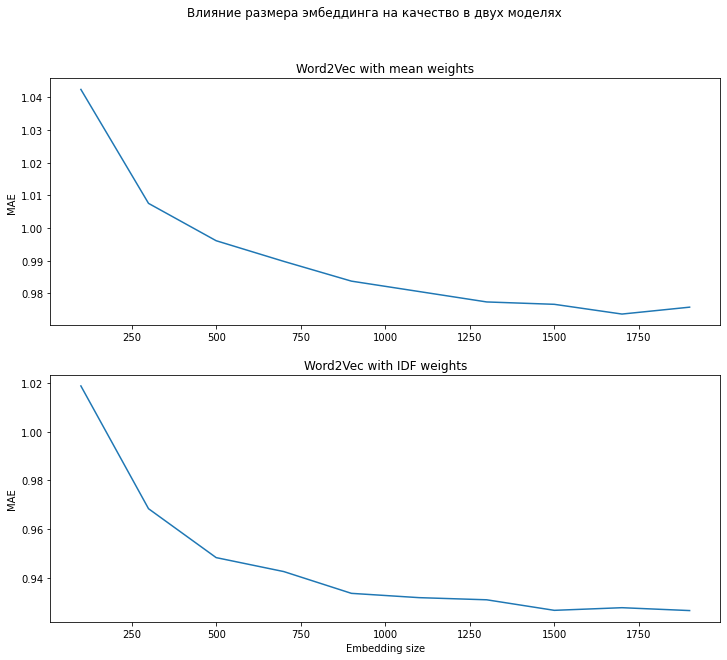

In [37]:
#рисуем графички
steps = np.arange(100, 2000, 200)

fig, axs = plt.subplots(2, figsize = (12,10))
axs[0].plot(steps, MAE_w2v)
axs[1].plot(steps, MAE_w2v_idf)
axs[0].set_title('Word2Vec with mean weights')
axs[1].set_title('Word2Vec with IDF weights')
axs[1].set_xlabel('Embedding size')
axs[0].set_ylabel('MAE')
axs[1].set_ylabel('MAE')

fig.suptitle('Влияние размера эмбеддинга на качество в двух моделях');

##### Выводы:

1. С увеличением размерности эмбеддингов качество становится лучше (лосс уменьшается), что логично, так как таким образом мы учитываем больше слов и их специфику в эмбеддингах

2. Word2Vec with IDF weights для каждой размерности показывает лучше качество, что тоже ожидаемо, так как в этой модели учитывается специфика и значимость каждого слова в текстах, а не берется просто среднее

3. После 1500 размерности качество у двух моделей почти остается на одном месте (а у Word2Vec даже немного ухудшается), из чего следует, что слишком большие эмбеддинги брать плохо, так как таким образом сложнее уловить некоторые специфические слова

#### Другие эмбеддинги

##### Fasttext

Теперь попробуйте обучить линейную регрессию на любых других эмбеддингах размерности 300 и сравните качество с Word2Vec.

In [38]:
from gensim.models import FastText

In [39]:
model1 = FastText(sentences = X_train_split, size=300, min_count=5)

In [40]:
X_train_fasttext = items_to_embed_w2v(X_train_split, model1)
X_test_fasttext = items_to_embed_w2v(X_test_split, model1)

In [41]:
Linreg1 = LinearRegression(normalize=True, n_jobs=3)
Linreg1.fit(X_train_fasttext, df_train['score'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=3, normalize=True)

In [42]:
score_fasttext = Linreg1.predict(X_test_fasttext)
mean_absolute_error(df_test['score'], score_fasttext)

1.0067195246167513

Сравним качество с **Word2Vec** и **Word2Vec with IDF weights** с таким же размером эмбеддинга - 300

In [43]:
mae_w2v(300)

1.0056713459068138

In [44]:
mae_w2v_idf(300)

0.9707595068039071

##### Выводы:

1. Fasttext позволяет определять близость слов на основе иерархической классификации, то есть строит дерево по словам, что позволяет выйти на неплохое качество в нашей задаче - МАЕ = 1.0067. 
Причем это несильно хуже, чем обычный Word2Vec со средними весами, показывающий при такой размерности эмбеддинга - МАЕ=1.0057, который использует в качестве метрике косинусное расстояние.

2. Word2Vec является одним из лучших инструментов для анализа текстов, показывающий качество лучше, чем другие способы для эмбеддинга текстов

3. Использование Word2Vec with IDF weights показывает наилучшее качество, так как использует мощный алгоритм для Word2Vec с весами IDF, более детально учитывающие специфику и значимость слов

### Часть 3. 6 баллов

Теперь давайте воспользуемся более продвинутыми методами обработки текстовых данных, которые мы проходили в нашем курсе. Обучите RNN/Transformer для предсказания пользовательской оценки. Получите ошибку меньше, чем во всех вышеперечисленных методах.

Если будете обучать RNN, попробуйте ограничить максимальную длину предложения. Некоторые отзывы могут быть слишком длинные относительно остальных.

Чтобы пользоваться DataLoader, все его элементы должны быть одинаковой размерности. Для этого вы можете добавить нулевой паддинг ко всем предложениям (см пример pad_sequence)

#### Пакеты и данные

In [45]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

In [46]:
is_cuda = torch.cuda.is_available() #проверка на GPU

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [47]:
WORDS = set()
for sent in list(df['positive']):
    for w in sent:
        WORDS.add(w)
        
for sent in list(df['negative']):
    for w in sent:
        WORDS.add(w)

In [48]:
int2word = dict(enumerate(tuple(WORDS)))
word2int = {w: ii for ii, w in int2word.items()}

In [49]:
MAX_LEN = max(max(df['positive'].apply(len)), max(df['negative'].apply(len)))

In [50]:
MAX_LEN

399

In [59]:
from torch.nn.utils.rnn import pad_sequence

train_pos_pad = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:200]) for seq in X_train_split], 
                           batch_first=True) #уберем слишком длинные предложения, отрежем последние 200
test_pos_pad = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:200]) for seq in X_test_split], 
                           batch_first=True) #уберем слишком длинные предложения, отрежем последние 200

In [61]:
#создадим датасеты
train_dataset = TensorDataset(torch.from_numpy(np.array(train_pos_pad)), torch.from_numpy(np.array(df_train['score'])))
test_dataset = TensorDataset(torch.from_numpy(np.array(test_pos_pad)), torch.from_numpy(np.array(df_test['score'])))

In [62]:
BATCH_SIZE = 1

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

#### Зададим LSTM (class RNN)

In [63]:
class RNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, n_hidden, n_layers):
        super(RNN, self).__init__()
        self.output_size = output_size #сколько будем выводить (равен 1, так как только пользовательская оценка)
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim) #эмбеддинг
        self.lstm = nn.LSTM(embedding_dim, n_hidden, n_layers, batch_first=True) #сам блок LSTM
        self.fc1 = nn.Linear(n_hidden, output_size) #линейный блок после LSTM
            
    def forward(self, x, hidden):
        embeds = self.embedding(x) #сначала делаем эмбеддинг
        lstm_out, (ht,ct) = self.lstm(embeds, hidden) #по эмбеддингу делаем LSTM
        return self.fc1(ht[-1]), (ht,ct) 
    #выводим линейное преобразование последнего скрытого слоя, по которому и будем предсказывать оценку + все скрытые слои (хотя можно это и не выводить)

    def init_hidden(self, batch_size): #зададим изначальный слой нулями
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        return hidden


In [64]:
vocab_size = len(word2int) + 1
output_size = 1
embedding_dim = 300 #поставим 300 для более четкого сравнения с предыдущими моделями
n_hidden = 64 #размерность скрытого слоя
n_layers = 3 #всего будет 3 скрытых слоя

model = RNN(vocab_size, output_size, embedding_dim, n_hidden, n_layers)
model.to(device)
print(model)

RNN(
  (embedding): Embedding(34729, 300)
  (lstm): LSTM(300, 64, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
)


In [65]:
lr=0.001 #шаг в оптимизаторе
criterion = nn.L1Loss() #L1Loss - позволяет считать MAE
optimizer = torch.optim.Adam(model.parameters(), lr=lr) #оптимизатор - АДАМ

#### Обучение LSTM

In [66]:
counter = 0
print_every = 25000 #будем валидироваться каждые 25000
clip = 5 #чтобы градиент не затухал
epochs=3 #поставим всего 3 эпохи

model.train()
for i in range(epochs):
    h = model.init_hidden(BATCH_SIZE) #зададим начальные слои
    
    for inputs, labels in tqdm(train_dataloader):
        counter += 1
        h = tuple([e.data for e in h]) #берем скрытые слои
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad() #обнуляем накопленные градиенты
        output, h = model(inputs, h) #обучаем модель
        loss = criterion(output.squeeze(), labels.long()) #определяем лосс
        loss.backward() #считаем лосс в модели
        nn.utils.clip_grad_norm_(model.parameters(), clip) #делаем так, чтобы не затухал градиент
        optimizer.step() #шаг оптимизатора

        if counter%print_every == 0: #каждые 25к отзывов валидируемся
            val_h = model.init_hidden(BATCH_SIZE) #создаем начальный слой
            val_losses = [] #все лоссы
            model.eval() #валидируем модель, не сохраняя результат в модель
            for inp, lab in tqdm(test_dataloader):
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab.float()) #считаем лосс
                val_losses.append(val_loss.item())
                
            model.train() #продолжаем обучать модель
            #выводим результаты
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))


Epoch: 1/3... Step: 25000... Loss: 1.225817... Val Loss: 1.563266



Epoch: 1/3... Step: 50000... Loss: 1.045159... Val Loss: 1.016121



Epoch: 1/3... Step: 75000... Loss: 1.270284... Val Loss: 1.021723




Epoch: 2/3... Step: 100000... Loss: 1.323348... Val Loss: 1.076796



Epoch: 2/3... Step: 125000... Loss: 0.277963... Val Loss: 0.948778



Epoch: 2/3... Step: 150000... Loss: 0.276326... Val Loss: 0.944744




Epoch: 3/3... Step: 175000... Loss: 2.083630... Val Loss: 1.071833



Epoch: 3/3... Step: 200000... Loss: 0.195287... Val Loss: 0.901648



Epoch: 3/3... Step: 225000... Loss: 0.008782... Val Loss: 0.927442



#### Вывод

Обученная LSTM модель дает качество МАЕ=0.9, что лучше, чем предыдущие модели (лучшее было 0.93 при большом размере эмбеддингов).

Это подтверждает мощность метода RNN и LSTM в частности, которая была использована в моей модели